In [2]:
import ensembles as es
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax.random as jr
from jax.config import config
import seaborn as sns
from glob import glob 
import numpy as np
import optax as ox
import xarray as xr
import copy

config.update("jax_enable_x64", True)
key = jr.PRNGKey(123)
sns.set_style('whitegrid')

%load_ext autoreload
%autoreload 2

%matplotlib inline

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
2022-05-25 10:30:07.609846: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Read

### Obs

In [1]:
def prepro(ds):
    model_real = ds.encoding['source'].split('_')[-1][:-3]
    ds = ds.assign_coords(realisation=model_real)
    return ds

/home/pindert2/bayesian_ensembling/ensembles/data.py:149: UserWarning: Collapsing (mean) non-time dimensions for plotting
  warnings.warn('Collapsing (mean) non-time dimensions for plotting')


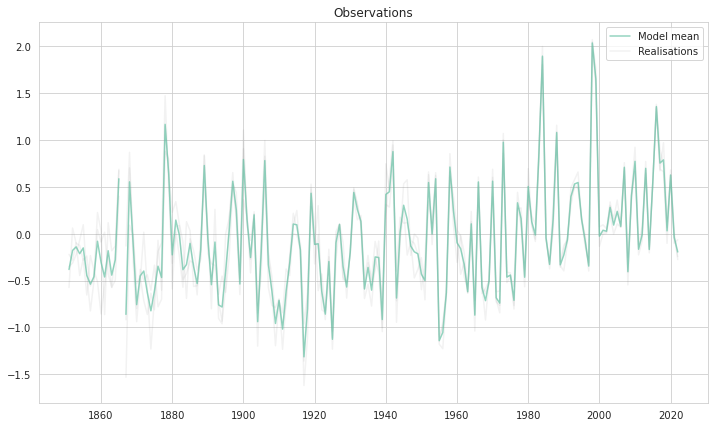

In [3]:
obs_da = xr.open_mfdataset(glob('./../experiments/data/obs/Had*.nc'), combine='nested', concat_dim='realization').tas.load()[:, :, 15:18, 15:19]
obs_da = obs_da.rename(realization='realisation')
obs_time = obs_da.time
obs_da = obs_da.resample(time='Y').mean()
observations = es.ProcessModel(obs_da, model_name='Observations')
observations.plot()

### Anomaly model data

In [4]:
cnrm_da = xr.open_mfdataset(glob('./../experiments/data/gridded/CNRM*.nc'), preprocess=prepro, combine='nested', concat_dim='realisation').tas.load().drop('height')[:, :, 15:18, 15:19]
can_da = xr.open_mfdataset(glob('./../experiments/data/gridded/CCC*.nc'), preprocess=prepro, combine='nested', concat_dim='realisation').tas.load().drop('height')[:, :, 15:18, 15:19]
ecearth_da = xr.open_mfdataset(glob('./../experiments/data/gridded/EC*.nc'), preprocess=prepro, combine='nested', concat_dim='realisation').tas.load().drop('height')[:, :, 15:18, 15:19]

can_da['time'] = cnrm_da['time']
ecearth_da['time'] = cnrm_da['time']

cnrm_model = es.ProcessModel(cnrm_da, 'CNRM')
cnrm_anomaly = cnrm_model.calculate_anomaly(resample_freq='Y')

can_model = es.ProcessModel(can_da, 'CAN')
can_anomaly = can_model.calculate_anomaly(resample_freq='Y')

ec_model = es.ProcessModel(ecearth_da, 'EC-EARTH')
ec_anomaly = ec_model.calculate_anomaly(resample_freq='Y')


/home/pindert2/bayesian_ensembling/ensembles/data.py:347: UserWarning: Collapsing (mean) non-time dimensions for plotting
  warnings.warn('Collapsing (mean) non-time dimensions for plotting')
/home/pindert2/bayesian_ensembling/ensembles/data.py:347: UserWarning: Collapsing (mean) non-time dimensions for plotting
  warnings.warn('Collapsing (mean) non-time dimensions for plotting')
/home/pindert2/bayesian_ensembling/ensembles/data.py:347: UserWarning: Collapsing (mean) non-time dimensions for plotting
  warnings.warn('Collapsing (mean) non-time dimensions for plotting')
/home/pindert2/bayesian_ensembling/ensembles/data.py:377: UserWarning: Collapsing (mean) non-time dimensions for plotting
  warnings.warn('Collapsing (mean) non-time dimensions for plotting')
/home/pindert2/bayesian_ensembling/ensembles/data.py:377: UserWarning: Collapsing (mean) non-time dimensions for plotting
  warnings.warn('Collapsing (mean) non-time dimensions for plotting')
/home/pindert2/bayesian_ensembling/ensem

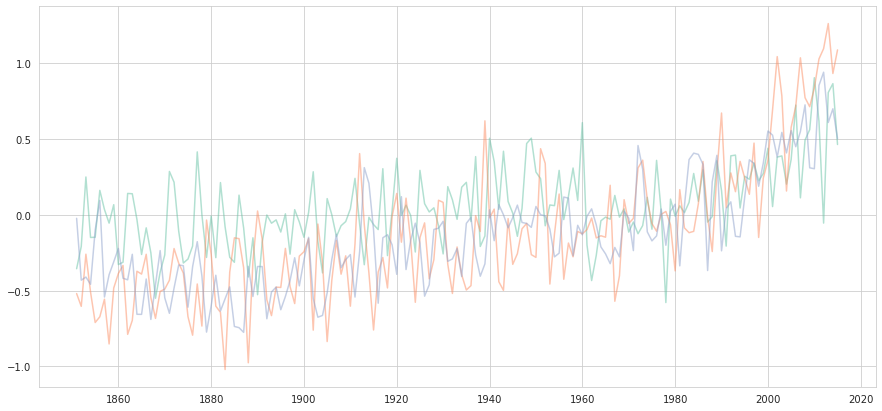

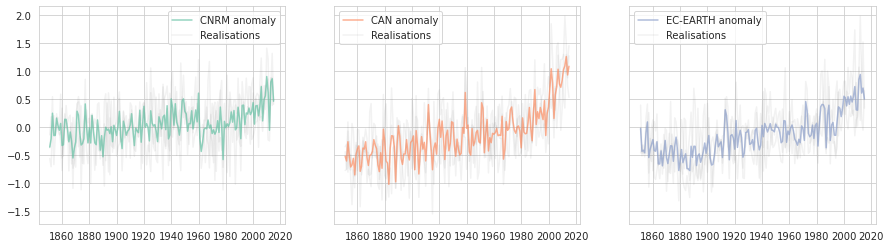

In [5]:
hist_anom_models = es.ModelCollection([cnrm_anomaly, can_anomaly, ec_anomaly])
hist_anom_models.plot_all()
hist_anom_models.plot_grid()


### Construct posteriors for historic data

In [6]:
import distrax as dx
from tslearn.barycenters import dtw_barycenter_averaging_subgradient
import gpflow as gpf
import tensorflow as tf
import tqdm

In [7]:
class _HeteroskedasticGaussian(gpf.likelihoods.Likelihood):
    def __init__(self, **kwargs):
        super().__init__(latent_dim=1, observation_dim=2, **kwargs)

    def _log_prob(self, F, Y):
        Y, NoiseVar = Y[:, 0], Y[:, 1]
        return gpf.logdensities.gaussian(Y, F, NoiseVar)

    def _variational_expectations(self, Fmu, Fvar, Y):
        Y, NoiseVar = Y[:, 0], Y[:, 1]
        Fmu, Fvar = Fmu[:, 0], Fvar[:, 0]
        return (
            -0.5 * np.log(2 * np.pi)
            - 0.5 * tf.math.log(NoiseVar)
            - 0.5 * (tf.math.square(Y - Fmu) + Fvar) / NoiseVar
        )

    # The following two methods are abstract in the base class.
    # They need to be implemented even if not used.

    def _predict_log_density(self, Fmu, Fvar, Y):
        raise NotImplementedError

    def _predict_mean_and_var(self, Fmu, Fvar):
        raise NotImplementedError

In [8]:
model = cnrm_anomaly

# Check coordinate names
assert 'latitude' in model.model_data.coords, "There must be a latitude coordinate in the dataArray"
assert 'longitude' in model.model_data.coords, "There must be a longitude coordinate in the dataArray"

# Check latitude is third dim
if np.where(np.asarray(model.model_data.dims) == 'latitude')[0][0] != 2:
    raise IndexError('Coordinate order should be realisation, time, latitude, longitude')

lats = model.model_data.latitude
lons = model.model_data.longitude

fitted_mean = np.zeros_like(model.model_data.values[0])
fitted_var = np.zeros_like(model.model_data.values[0])

# Could parallelize this...
for i, lat in enumerate(lats):
    for j, lon in enumerate(lons):
        realisation_set = model.model_data.sel(latitude=lat, longitude=lon).values
        y_mean = dtw_barycenter_averaging_subgradient(realisation_set, max_iter=50, tol=1e-3).squeeze()
        y_var = np.var(realisation_set, axis=0)
        fitted_mean[:, i, j] = y_mean
        fitted_var[:, i, j] = y_var

mean_array = copy.deepcopy(model.model_data.isel(realisation=0)).drop_vars('realisation')
mean_array.data = fitted_mean
var_array = copy.deepcopy(model.model_data.isel(realisation=0)).drop_vars('realisation')
var_array.data = fitted_var

lon_grid, lat_grid = np.meshgrid(mean_array.longitude, mean_array.latitude)
x = np.cos(lat_grid * np.pi / 180)  * np.cos(lon_grid * np.pi / 180)
y = np.cos(lat_grid * np.pi / 180)  * np.sin(lon_grid * np.pi / 180)
z = np.sin(mean_array.latitude.values * np.pi / 180)

# Would want to add in some periodic time probably if using monthly data
t_cont = np.arange(len(mean_array.time))
t_cont = 2 * t_cont / np.max(t_cont) - 1
t_month = mean_array.time.dt.month.values
t_sin = np.sin(2 * np.pi * t_month / 12)
t_cos = np.cos(2 * np.pi * t_month / 12)


mean_array = mean_array.assign_coords(
                x=(["latitude", 'longitude'], x),
                y=(["latitude", 'longitude'], y),
                z=("latitude", z),
                t_cont=("time", t_cont),
                t_sin=("time", t_sin),
                t_cos=("time", t_cos),
                )

# X includes:
#   - all of the above custom coords (x,y,z,t_cont,t_sin,t_cos)
#   - all of the realisations 
X = np.concatenate(
    [mean_array.to_dataframe().drop(mean_array.name, axis=1).values,
    model.model_data.to_dataframe().tas.values.reshape(len(model.model_data.realisation), -1).T],
    axis=1).astype(np.float64)

Y = np.concatenate(
    [
        mean_array.to_dataframe()[mean_array.name].values.reshape(-1, 1),
        var_array.to_dataframe()[var_array.name].values.reshape(-1, 1)
    ],
    axis=1).astype(np.float64)

/home/pindert2/miniconda3/envs/bayesian_ensembles/lib/python3.8/site-packages/tslearn/barycenters/dba.py:735: ConvergenceWarning: DBA loss is increasing while it should not be. Stopping optimization.
  warnings.warn("DBA loss is increasing while it should not be. "


In [10]:
likelihood = _HeteroskedasticGaussian()
time_kernel = gpf.kernels.Matern32(active_dims=[3, 4, 5])
x_y_kernel = gpf.kernels.Matern32(active_dims=[0, 1])
z_kernel = gpf.kernels.Matern32(active_dims=[2])
realisation_kernel = gpf.kernels.Matern32(active_dims=list(np.arange(6, 6 + model.n_realisations)))

kernel = time_kernel + x_y_kernel + z_kernel + realisation_kernel
gp_model = gpf.models.GPMC((X, Y), kernel=kernel, likelihood=likelihood, num_latent_gps=1)

# natgrad = gpf.optimizers.NaturalGradient(gamma=0.05)
adam = tf.optimizers.Adam(0.01)

# gpf.utilities.set_trainable(gp_model.q_mu, False)
# gpf.utilities.set_trainable(gp_model.q_sqrt, False)


loss = tf.function(gp_model.training_loss)

In [12]:
with tf.GradientTape() as tape:
    tape.watch(gp_model.trainable_variables)
    obj = loss()
grads = tape.gradient(obj, gp_model.trainable_variables)

In [13]:
adam.apply_gradients(zip(grads, gp_model.trainable_variables))

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1>

In [11]:
gpf.utilities.print_summary(gp_model, fmt='notebook')

name,class,transform,prior,trainable,shape,dtype,value
GPMC.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,1.0
GPMC.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1.0
GPMC.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.0
GPMC.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,1.0
GPMC.kernel.kernels[2].variance,Parameter,Softplus,,True,(),float64,1.0
GPMC.kernel.kernels[2].lengthscales,Parameter,Softplus,,True,(),float64,1.0
GPMC.kernel.kernels[3].variance,Parameter,Softplus,,True,(),float64,1.0
GPMC.kernel.kernels[3].lengthscales,Parameter,Softplus,,True,(),float64,1.0
GPMC.V,Parameter,Identity,Normal,True,"(1980, 1)",float64,[[0....


In [12]:
tr = tqdm.trange(10)
losses = []

for i in tr:
    # natgrad.minimize(loss, [(gp_model.q_mu, gp_model.q_sqrt)])
    adam.minimize(loss, gp_model.trainable_variables)
    if i % 1 == 0:
        l = loss().numpy()
        tr.set_postfix({"loss": f"{l :.2f}"})
        losses.append(l)

100%|██████████| 10/10 [00:13<00:00,  1.40s/it, loss=44424817.69]


In [ ]:
hist_anom_models.fit(model=es.GPDTW(), compile_objective=True)

In [ ]:
model_idx = 0
mu = hist_anom_models[model_idx].distribution.mean()
stddev = hist_anom_models[model_idx].distribution.stddev()
realisations = hist_anom_models[model_idx].model_data.values

fig,ax = plt.subplots(figsize=(20,8))
ax.plot(hist_anom_models[model_idx].time, mu, color='tab:blue', label='Predicted mean', linewidth=2, zorder=2)
ax.fill_between(hist_anom_models[model_idx].time.values, mu - stddev, mu + stddev, color='tab:blue', alpha=0.2, label='One sigma', zorder=2)
ax.plot(hist_anom_models[model_idx].time, realisations.T, color='tab:gray', alpha=0.2, zorder=1, linewidth=0.7)
ax.legend(loc='best')
ax.set_title(f'Mean Field Approximation {hist_anom_models[model_idx].model_name}')
plt.show()

In [ ]:
weight_function = es.LogLikelihoodWeight()
weights = weight_function(hist_anom_models, observations)

In [ ]:
ensemble = es.Barycentre()
pdfs = ensemble(hist_anom_models, weights)

### Hindcast ensemble

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))
hist_anom_models.plot_all(one_color='tab:gray', ax=ax)
ensemble.plot(ax, x=hist_anom_models.time.values)
ax.legend(loc='best')

### Forecast Ensemble

In [ ]:
ssp_anom_models.fit(model=es.GPDTW(), compile_objective=True, n_optim_nits=1000)

### Calculate weights using different schemes

In [ ]:
uniform_weights = es.UniformWeight()(hist_anom_models)
mse_weights = es.InverseSquareWeight()(hist_anom_models, observations)

weight_function = es.LogLikelihoodWeight()
ll_weights = weight_function(hist_anom_models, observations)

### Construct different ensemble outputs

In [ ]:
weighted_mean = es.WeightedModelMean()(hist_anom_models, weights=mse_weights)
multi_model_mean = es.MultiModelMean()(hist_anom_models)
weighted_barycentre = es.Barycentre()(hist_anom_models, weights=ll_weights)